In [1]:
import json
import os
import numpy as np
import pandas as pd
import dgl
import dgl.function as fn

import torch
import torch.nn as nn

import gc

/opt/anaconda3/envs/CSH/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocess

In [2]:
folder = 'Patents'
path = '/root/TKDE/data'
is_vocabulary = True

meta_data_path = {
    "patent": "abstract.csv",
    "company": "Assignees-token.csv",
    "applicant": "Applicants-token.csv",
    "patent_filter": "patent-filter.csv",
    "company_filter": "company-filter.csv",
    "applicant_filter":"applicant-filter.csv",
}
center_node_type = "patent"
center_edge = ('patent', 'applicant')
feat_name = {
    "applicant": "A",
    "company": "C",
    "patent": "P"
}

edge_name = {
    'applicant_patent': ['A', 'P'],
    'company_patent': ['C', 'P'],
    'patent_applicant': ['P', 'A'],
    'patent_company': ['P', 'C'],
}

link_prediction_type = 'company_patent'

In [3]:
data_dict = {}
for k in meta_data_path:
    data_path = os.path.join(folder, meta_data_path[k])
    data_dict[k] = pd.read_csv(data_path).dropna().drop_duplicates()

In [4]:
graph_path = os.path.join(folder, 'model', 'bert_raw.pkl')
dataset = dgl.load_graphs(graph_path)
graph = dataset[0][0]
etypes = {ntype: [] for ntype in graph.ntypes}
embedding = dict()
for ntype in graph.ntypes:
    if "feat" in graph.nodes[ntype].data:
        embedding[ntype] = graph.nodes[ntype].data["feat"]

node_num = {}
nodeEmb = nn.ModuleDict()
for ntype in graph.ntypes:
    node_num[ntype] = len(graph.nodes(ntype))
    nor_feat = graph.nodes[ntype].data["feat"]

    nodeEmb[ntype] = nn.Embedding.from_pretrained(
        torch.cat([nor_feat, torch.zeros(1, nor_feat.shape[1])], dim=0), freeze=True)

for stype, etype, dtype in graph.canonical_etypes:
    etypes[stype].append((etype, dtype))

In [5]:
# Remove the node without text
graph_node_set = set(graph.nodes(center_node_type).numpy().tolist())
text_node_set = set(data_dict[center_node_type]["patentIdMap"].values)
null_value_list = list(graph_node_set ^ text_node_set)
not_null_value_list = list(graph_node_set & text_node_set)
graph = dgl.remove_nodes(graph, torch.tensor(null_value_list), ntype=center_node_type)
data_dict[center_node_type].sort_values(by=['patentIdMap'],ascending=True)
data_dict[center_node_type]['patentIdMap'] = np.arange(len(data_dict[center_node_type]))

dgl.save_graphs(os.path.join(folder, 'model', 'bert_infer.pkl') , graph)

In [6]:
texts = []
for x in data_dict[center_node_type].values[:, -1]:
    text = str(x).replace(" ", "")[1:-1].split(",")[1:]
    texts.append(' '.join(text))


In [7]:
return_dict = [{ntype: [] for ntype in etypes.keys()} for i in range(3)]
def sampleNei(ntype: dict, etypes: list, nei_num: int) -> dict:
        neigh_layer_1 = dgl.sampling.sample_neighbors(graph, ntype, nei_num, edge_dir='out')
        neigh_nodes = {dtype: set() for etype, dtype in etypes}
        for etype_tuple in etypes:
            etype, dsttype = etype_tuple
            neigh_nodes[dsttype].update(neigh_layer_1.edges(etype=etype)[1].unique().numpy().tolist())
        for ntype, nodes in neigh_nodes.items():
            neigh_nodes[ntype] = nodes
        return neigh_nodes
nei_num = 5
graph_neighbours = {}
for nid in graph.nodes(center_node_type).numpy().tolist():
    graph_neighbour = sampleNei({center_node_type: [nid]}, etypes[center_node_type], nei_num)
    patent_neighbour = []
    for k in graph_neighbour:
        graph_neighbour[k] = list(graph_neighbour[k])
        tmp_neighbour_nodes = list(sampleNei({k: graph_neighbour[k]}, [(k+'_patent', 'patent')], nei_num)['patent'])
        patent_neighbour += tmp_neighbour_nodes
    patent_neighbour = set(patent_neighbour)
    if nid in tmp_neighbour_nodes:
        patent_neighbour.remove(nid)
    graph_neighbour[center_node_type] = list(patent_neighbour)[:nei_num]
    graph_neighbours[nid] = graph_neighbour


KeyboardInterrupt: 

In [ ]:
torch.manual_seed(seed=2024)
train_rate, test_rate = 0.7, 0.1
node_len = graph.number_of_nodes(center_node_type)
permute_idx = torch.randperm(node_len)
train_len, test_len = int(node_len*train_rate), int(node_len*test_rate)
node_split_idx = {'train':{center_node_type: torch.tensor(permute_idx[:train_len])}, 
                  'valid':{center_node_type: torch.tensor(permute_idx[train_len:node_len-test_len])},
                  'test':{center_node_type: torch.tensor(permute_idx[node_len-test_len:])}}

edge_split_idx = {}

for k in node_split_idx:
    edge_idx_lst = []
    for node_id in node_split_idx[k][center_node_type]:
        edge_idx = graph.in_edges(node_id, etype=link_prediction_type,form='eid')
        if len(edge_idx) != 0:
            edge_idx_lst.append(int(edge_idx[0]))
    edge_split_idx[k] = {center_node_type: torch.tensor(edge_idx_lst)}



/tmp/ipykernel_248640/1905231611.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_split_idx = {'train':{center_node_type: torch.tensor(permute_idx[:train_len])},
/tmp/ipykernel_248640/1905231611.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'valid':{center_node_type: torch.tensor(permute_idx[train_len:node_len-test_len])},
/tmp/ipykernel_248640/1905231611.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'test':{center_node_type: torch.tensor(permute_idx[node_len-test_len:])}}


In [ ]:
torch.save(node_split_idx, os.path.join(folder, 'downstream', 'node_split_idx.pkl'))
torch.save(edge_split_idx, os.path.join(folder, 'downstream', 'edge_split_idx.pkl'))


In [24]:
g = graph.clone()

# Combine edges of different types into one type
# src_cites, dst_cites = g.edges(etype='cites')
# src_rev_cites, dst_rev_cites = g.edges(etype='rev_cites')

# new_src = torch.cat([src_cites, src_rev_cites])
# new_dst = torch.cat([dst_cites, dst_rev_cites])

# # Get the edge IDs of the original edges
# edge_ids_cites = g.edge_ids(src_cites, dst_cites, etype='cites').squeeze()
# edge_ids_rev_cites = g.edge_ids(src_rev_cites, dst_rev_cites, etype='rev_cites').squeeze()

# # Remove the original edges using edge IDs
# g.remove_edges(edge_ids_cites, etype='cites')
# g.remove_edges(edge_ids_rev_cites, etype='rev_cites')

# # Add the combined edges with a new edge type
# g.add_edges(new_src, new_dst, etype='cites')

# 获得所有边类型
edge_types = g.etypes
filtered_edge_types = [etype for etype in edge_types if etype != 'rev_cites']
g = g.edge_type_subgraph(filtered_edge_types)

# 遍历节点数据字典，创建新的键并复制值
for k in feat_name:
    tmp = g.nodes[k].data['feat']
    g.nodes[k].data.clear()
    g.nodes[k].data[feat_name[k]] = tmp


In [25]:
new_edges = {}
edge_types = g.etypes
for edge_type in edge_types:
    adj = g.edges(etype=edge_type)
    src_type, dst_type = edge_name[edge_type]
    new_edges[(src_type, src_type+'-'+dst_type, dst_type)] = adj

new_graph = dgl.heterograph(new_edges)

for k in feat_name:
    v = feat_name[k]
    new_graph.nodes[v].data[v] = g.nodes[k].data[v]

g = new_graph

In [23]:
def hg_propagate_feat_dgl(g, tgt_type, num_hops, max_length, extra_metapath, echo=False):
    for hop in range(1, max_length):
        reserve_heads = [ele[:hop] for ele in extra_metapath if len(ele) > hop]
        for etype in g.etypes:
            stype, _, dtype = g.to_canonical_etype(etype)
            # if hop == args.num_hops and dtype != tgt_type: continue
            for k in list(g.nodes[stype].data.keys()):
                if len(k) == hop:
                    current_dst_name = f'{dtype}{k}'
                    # if (hop == num_hops and dtype != tgt_type and k not in reserve_heads) \
                    #   or (hop > num_hops and k not in reserve_heads):
                    #     continue
                    if echo: print(k, etype, current_dst_name)
                    # AI A-I IAI
                    g[etype].update_all(
                        fn.copy_u(k, 'm'),
                        fn.mean('m', current_dst_name), etype=etype)

        # remove no-use items
        for ntype in g.ntypes:
            if ntype == tgt_type: continue
            removes = []
            for k in g.nodes[ntype].data.keys():
                if len(k) <= hop:
                    removes.append(k)
            for k in removes:
                g.nodes[ntype].data.pop(k)
            if echo and len(removes): print('remove', removes)
        gc.collect()

        if echo: print(f'-- hop={hop} ---')
        # for ntype in g.ntypes:
        #     for k, v in g.nodes[ntype].data.items():
        #         print(f'{ntype} {k} {v.shape}', v[:,-1].max(), v[:,-1].mean())
        # if echo: print(f'------\n')
    return g

In [26]:
extra_metapath = []
num_hops = 4
g = hg_propagate_feat_dgl(g, center_node_type, num_hops, num_hops, extra_metapath, echo=True)

A A-P PA
C C-P PC
P P-A AP
P P-C CP
remove ['A']
remove ['C']
remove ['P']
-- hop=1 ---
AP A-P PAP
CP C-P PCP
PA P-A APA
PC P-A APC
PA P-C CPA
PC P-C CPC
remove ['AP']
remove ['CP']
remove ['PA', 'PC']
-- hop=2 ---
APA A-P PAPA
APC A-P PAPC
CPA C-P PCPA
CPC C-P PCPC
PAP P-A APAP
PCP P-A APCP
PAP P-C CPAP
PCP P-C CPCP
remove ['APA', 'APC']
remove ['CPA', 'CPC']
remove ['PAP', 'PCP']
-- hop=3 ---


In [12]:
tgt_type = feat_name[center_node_type]
raw_feats = {}
keys = list(g.nodes[tgt_type].data.keys())

for k in keys:
    raw_feats[k] = g.nodes[tgt_type].data.pop(k)
feats = {k: v.detach().clone() for k, v in raw_feats.items()}
feats_path = os.path.join(folder, 'feats_4.npy')
np.save(feats_path, feats) # 注意带上后缀名

# Generate Pretrain Data

In [15]:
# graph_neighbours
# graph_neighbours_path = os.path.join(folder, 'train_pp_graph_neighbour.npy')
# np.save(graph_neighbours_path, graph_neighbours) # 注意带上后缀名
 
graph_neighbours_path = os.path.join(folder, 'train_pp_graph_neighbour.npy')
load_dict = np.load(graph_neighbours_path, allow_pickle=True).item()
graph_neighbours = load_dict

In [17]:
for t in texts:
    if '\n' in t:
        print("YES")
        break

In [16]:
def write_for_pp(file, mode='train'):
    '''
    paper: P, field_of_study: F, author: A
    Each line is in this format:
    query_P \t q_n_P \t q_n_A \t q_n_F \$\$ key_P \t k_n_P \t k_n_A \t k_n_F 
    '''
    input_id = node_split_idx[mode][center_node_type]
    no_paper_neighbour = 0
    false_text = 0
    all_id_set = set(graph_neighbours.keys())
    with open(file,'w') as fout:
        for idd in input_id:
            idd = int(idd)
            # sample query node & neighbour
            query_n_paper = graph_neighbours[idd][center_node_type]
            
            ## generate key paper
            n = list(set(query_n_paper) & all_id_set)
            if len(query_n_paper) != 0 and len(n) != 0:
                n = n[0]
            else:
                n = idd

            # generate query text
            query_text = texts[idd]
            # generate key text
            key_text = texts[n]
            ## summary
            id_lst = [str(idd), str(n)]
            write_down = '\t'.join(id_lst) +'\$\$'+ query_text+'\$\$'+key_text+'\n'
            a = write_down.strip().split('\$\$')
            if a[1] == query_text and a[2] == key_text:
                if '\n' not in query_text and '\n' not in key_text:
                    fout.write(write_down)
                else:
                    false_text += 1
            else:
                false_text += 1

    print(f'Finish writing data into {file}')
    print(f'No neighbour paper:{no_paper_neighbour}, all:{len(input_id)}')
    print(f'false_text:{false_text}')
    print('****************************')

In [17]:
write_for_pp(file=os.path.join(folder, 'train_pp.tsv'), mode='train')
write_for_pp(file=os.path.join(folder, 'valid_pp.tsv'), mode='valid')
write_for_pp(file=os.path.join(folder, 'test_pp.tsv'), mode='test')


Finish writing data into Patents/train_pp.tsv
No neighbour paper:0, all:253930
false_text:0
****************************
Finish writing data into Patents/valid_pp.tsv
No neighbour paper:0, all:72553
false_text:0
****************************
Finish writing data into Patents/test_pp.tsv
No neighbour paper:0, all:36275
false_text:0
****************************


In [18]:

def write_for_downstream_pp(file, mode='train'):
    '''
    Each line is in this format:
    query_paper \t q_n_paper1 \t...\t q_paperK \t q_n_author1 \t...\t q_authorM \t q_venue \$\$ key_paper \t k_n_paper1 \t...\t k_n_paperK \t k_n_author1 \t...\t k_aM \t k_venue 
    K = paper_neighbour_num
    M = author_neighbour_num
    '''
    no_paper_neighbour = 0
    false_text = 0
    with open(file,'w') as fout:
        for idd in graph.nodes(center_node_type).numpy().tolist():
            id_lst = [str(idd)]
            query_text = texts[idd]

            ## summary
            write_down = '\t'.join(id_lst) +'\$\$'+ query_text+'\n'
            a = write_down.strip().split('\$\$')
            if a[1] == query_text:
                if '\n' not in query_text:
                    fout.write(write_down)
                else:
                    false_text += 1
            else:
                false_text += 1
    print(f'Finish writing data into {file}')
    print(f'No neighbour paper:{no_paper_neighbour}, all:{len(graph.nodes(center_node_type))}')
    print(f'false_text:{false_text}')
    print('****************************')


In [19]:
write_for_downstream_pp(file=os.path.join(folder, 'infer_pp.tsv'), mode='infer')

Finish writing data into Patents/infer_pp.tsv
No neighbour paper:0, all:362758
false_text:0
****************************


In [ ]:
# T-SNE

# T-SNE

In [16]:
import numpy as np
from sklearn.manifold import TSNE

In [73]:

melon_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_infer_feats4_R_HGNN.pkl'
linkbert_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_linkbert_R_HGNN.pkl'
patton_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_patton_R_HGNN.pkl'
roberta_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_roberta_R_HGNN.pkl'
graphormer_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_graphformer_R_HGNN.pkl'
bert_path = '/home/chenshangheng/Desktop/MELON/downstream/save_emb/OAG_Venue/bert_Bert_R_HGNN.pkl'





In [79]:
import seaborn as sns
import pandas as pd

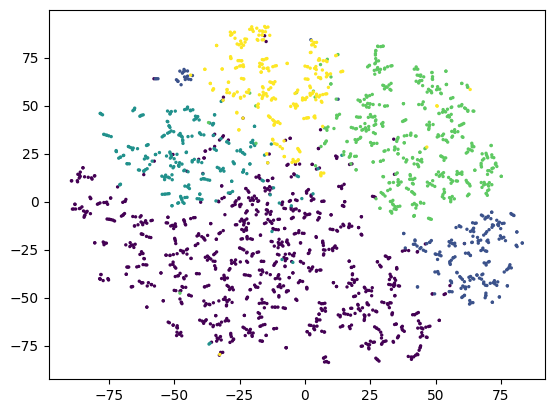

In [87]:
graph_path = os.path.join(folder, 'model', 'bert_Bert.pkl')
dataset = dgl.load_graphs(graph_path)
graph = dataset[0][0]
# X = np.array(graph.nodes[center_node_type][0]['feat'].tolist())
labels = np.array(dataset[1]['paper'].squeeze(1).tolist())
idx = labels < 5
X = torch.load(roberta_path)['paper'].cpu()
X = X[idx]
labels = labels[idx]

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(X)

df = pd.DataFrame(
    {'x': X_embedded[:, 0],
     'y': X_embedded[:, 1],
     'label': labels}
)

from matplotlib import pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], 2, labels)